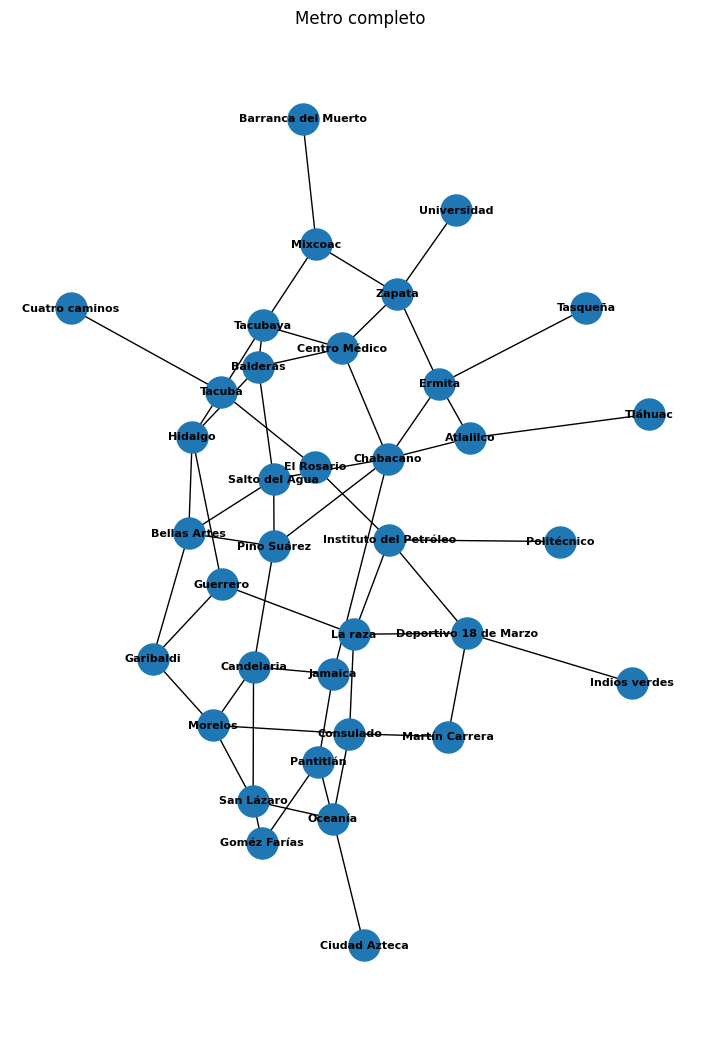

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

all_stations = [
    # Linea rosa (line 1)
    ('Tacubaya', 'Balderas', {'weight': 6}),
    ('Balderas', 'Salto del Agua', {'weight': 1}),
    ('Salto del Agua', 'Pino Suárez', {'weight': 2}),
    ('Pino Suárez', 'Candelaria', {'weight': 2}),
    ('Candelaria', 'San Lázaro', {'weight': 1}),
    ('San Lázaro', 'Goméz Farías', {'weight': 4}),
    ('Goméz Farías', 'Pantitlán', {'weight': 2}),
    # Linea azul marino (line 2)
    ('Cuatro caminos', 'Tacuba', {'weight': 1}),
    ('Tacuba', 'Hidalgo', {'weight': 7}),
    ('Hidalgo', 'Bellas Artes', {'weight': 1}),
    ('Bellas Artes', 'Pino Suárez', {'weight': 3}),
    ('Pino Suárez', 'Chabacano', {'weight': 2}),
    ('Chabacano', 'Ermita', {'weight': 6}),
    ('Ermita', 'Tasqueña', {'weight': 1}),
    # Linea amarilla fuerte (line 3)
    ('Indios verdes', 'Deportivo 18 de Marzo', {'weight': 1}),
    ('Deportivo 18 de Marzo', 'La raza', {'weight': 2}),
    ('La raza', 'Guerrero', {'weight': 2}),
    ('Guerrero', 'Hidalgo', {'weight': 1}),
    ('Hidalgo', 'Balderas', {'weight': 2}),
    ('Balderas', 'Centro Médico', {'weight': 3}),
    ('Centro Médico', 'Zapata', {'weight': 4}),
    ('Zapata', 'Universidad', {'weight': 2}),
    # Linea azul turquesa (line 4)
    ('Martín Carrera', 'Consulado', {'weight': 3}),
    ('Consulado', 'Morelos', {'weight': 2}),
    ('Morelos', 'Candelaria', {'weight': 1}),
    ('Candelaria', 'Jamaica', {'weight': 2}),
    # Linea amarilla (line 5)
    ('Politécnico', 'Instituto del Petróleo', {'weight': 1}),
    ('Instituto del Petróleo', 'La raza', {'weight': 2}),
    ('La raza', 'Consulado', {'weight': 3}),
    ('Consulado', 'Oceanía', {'weight': 3}),
    ('Oceanía', 'Pantitlán', {'weight': 3}),
    # Linea roja (line 6)
    ('El Rosario', 'Instituto del Petróleo', {'weight': 6}),
    ('Instituto del Petróleo', 'Deportivo 18 de Marzo', {'weight': 2}),
    ('Deportivo 18 de Marzo', 'Martín Carrera', {'weight': 1}),
    # Linea naranja (line 7)
    ('Barranca del Muerto', 'Mixcoac', {'weight': 1}),
    ('Mixcoac', 'Tacubaya', {'weight': 3}),
    ('Tacubaya', 'Tacuba', {'weight': 5}),
    ('Tacuba', 'El Rosario', {'weight': 4}),
    # Linea naranja (line 8)
    ('Garibaldi', 'Bellas Artes', {'weight': 1}),
    ('Bellas Artes', 'Salto del Agua', {'weight': 2}),
    ('Salto del Agua', 'Chabacano', {'weight': 3}),
    ('Chabacano', 'Atlalilco', {'weight': 8}),
    ('Atlalilco', 'Tláhuac', {'weight': 1}),
    # Linea cafe (line 9)
    ('Tacubaya', 'Centro Médico', {'weight': 3}),
    ('Centro Médico', 'Chabacano', {'weight': 2}),
    ('Chabacano', 'Jamaica', {'weight': 1}),
    ('Jamaica', 'Pantitlán', {'weight': 5}),
    # Línea carne (line 12)
    ('Mixcoac', 'Zapata', {'weight': 3}),
    ('Zapata', 'Ermita', {'weight': 3}),
    ('Ermita', 'Atlalilco', {'weight': 2}),
    ('Atlalilco', 'Tláhuac', {'weight': 1}),
    # Línea verde-azul (Line B)
    ('Guerrero', 'Garibaldi', {'weight': 1}),
    ('Garibaldi', 'Morelos', {'weight': 3}),
    ('Morelos', 'San Lázaro', {'weight': 1}),
    ('San Lázaro', 'Oceanía', {'weight': 3}),
    ('Oceanía', 'Ciudad Azteca', {'weight': 1})
]

G.add_edges_from(all_stations)

plt.figure(figsize=(7, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, font_size=8)
plt.title('Metro completo')
plt.show()

In [7]:
import random
import numpy
from deap import creator, base, tools, algorithms

# Constantes del algoritmo genético
POPULATION_SIZE = 10000
P_CROSSOVER = 0.8  # probabilidad de cruce
P_MUTATION = 0.2   # probabilidad de mutación
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 5

# la semilla aleatoria, 42 es la universal
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Crear los objetos de DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Mapeo de estaciones a índices
station_to_index = {station: i for i, station in enumerate(G.nodes)}
index_to_station = {i: station for station, i in station_to_index.items()}

def crossover_connected_routes(ind1, ind2):
    # Encuentra puntos de cruce que sean estaciones adyacentes para ambos padres
    possible_crossover_points = [i for i in range(1, len(ind1)-1) if G.has_edge(index_to_station[ind1[i]], index_to_station[ind2[i+1]]) and G.has_edge(index_to_station[ind2[i]], index_to_station[ind1[i+1]])]
    if not possible_crossover_points:
        return ind1, ind2

    crossover_point = random.choice(possible_crossover_points)
    
    # Crea nuevos hijos asegurando que las estaciones sean consecutivas en el grafo
    new_ind1 = ind1[:crossover_point] + ind2[crossover_point:]
    new_ind2 = ind2[:crossover_point] + ind1[crossover_point:]

    # Reparar hijos en caso de rutas inválidas
    new_ind1 = repair_route(new_ind1)
    new_ind2 = repair_route(new_ind2)
    
    return new_ind1, new_ind2

# Función de reparación que elimina estaciones no consecutivas
def repair_route(route):
    repaired_route = [route[0]]
    for station in route[1:]:
        if G.has_edge(index_to_station[repaired_route[-1]], index_to_station[station]):
            repaired_route.append(station)
        else:
            # Encuentra la estación conectada más cercana y ajústala
            connected_stations = [s for s in G.neighbors(index_to_station[repaired_route[-1]])]
            repaired_route.append(station_to_index[random.choice(connected_stations)])
    return repaired_route

# Registrar la nueva función de cruce en la caja de herramientas
toolbox.register("mate", crossover_connected_routes)

# Creo una función para generar permutaciones aleatorias de indices de las estaciones
def random_route_indices():
    middle_stations = list(station_to_index.values())
    middle_stations.remove(station_to_index["El Rosario"])
    middle_stations.remove(station_to_index["San Lázaro"])
    random_route = random.sample(middle_stations, len(middle_stations))
    return [station_to_index["El Rosario"]] + random_route + [station_to_index["San Lázaro"]]

toolbox.register("individualCreator", tools.initIterate, creator.Individual, random_route_indices)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# Calculando el fitness - el tiempo total para cada ruta:
def route_time_indices(individual):
    total_time = 0
    for i in range(1, len(individual)):
        if G.has_edge(index_to_station[individual[i-1]], index_to_station[individual[i]]):
            total_time += G[index_to_station[individual[i-1]]][index_to_station[individual[i]]]['weight']
        else:
            total_time += 1000000  # Penalización aumentada por ruta inválida
    return total_time,

toolbox.register("evaluate", route_time_indices)

# Operadores genéticos
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(G.nodes))

# Imprimimos los resultados
def print_friendly_results(hof):
    print("\n---------------- Mejores Rutas Encontradas ----------------")
    for i, individual in enumerate(hof.items):
        route = [index_to_station[index] for index in individual]
        print(f"\nRuta {i+1} con el Tiempo Más Corto ({individual.fitness.values[0]} minutos):")
        print(" -> ".join(route))

# Flujo del algoritmo genético
def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    print_friendly_results(hof)

    return population, logbook, hof

main()

gen	nevals	min    	avg       
0  	10000 	2.5e+07	3.1953e+07
1  	8412  	2.4e+07	3.11424e+07
2  	8485  	2.4e+07	3.06691e+07
3  	8434  	2.4e+07	3.03753e+07
4  	8393  	2.3e+07	3.01386e+07
5  	8434  	1.9e+07	2.99399e+07
6  	8351  	1.9e+07	2.98087e+07
7  	8394  	2.2e+07	2.97059e+07
8  	8316  	2.2e+07	2.95026e+07
9  	8429  	2e+07  	2.94848e+07
10 	8432  	2e+07  	2.9423e+07 
11 	8358  	2.2e+07	2.93859e+07
12 	8341  	2.1e+07	2.93011e+07
13 	8435  	2e+07  	2.92886e+07
14 	8404  	2e+07  	2.92289e+07
15 	8380  	2e+07  	2.92234e+07
16 	8404  	2e+07  	2.92055e+07
17 	8383  	2e+07  	2.91858e+07
18 	8360  	2e+07  	2.91492e+07
19 	8451  	2e+07  	2.91042e+07
20 	8434  	1.8e+07	2.90776e+07
21 	8505  	1.8e+07	2.9145e+07 
22 	8386  	1.8e+07	2.91308e+07
23 	8456  	1.8e+07	2.91242e+07
24 	8398  	2e+07  	2.90852e+07
25 	8343  	2.1e+07	2.90796e+07
26 	8464  	2e+07  	2.91222e+07
27 	8319  	2e+07  	2.91075e+07
28 	8322  	2e+07  	2.90579e+07
29 	8373  	1.9e+07	2.90594e+07
30 	8450  	1.9e+07	2.90667e+07
31 	8460  

([[2,
   34,
   16,
   35,
   4,
   15,
   30,
   31,
   7,
   9,
   17,
   28,
   22,
   18,
   0,
   32,
   25,
   24,
   6,
   27,
   19,
   3,
   33,
   26,
   5,
   1,
   11,
   23,
   8,
   29,
   12,
   10,
   14,
   13,
   20,
   21],
  [34,
   33,
   12,
   6,
   25,
   2,
   16,
   27,
   10,
   0,
   5,
   19,
   32,
   1,
   29,
   11,
   22,
   9,
   3,
   4,
   26,
   35,
   30,
   31,
   20,
   21,
   8,
   24,
   28,
   18,
   7,
   13,
   14,
   23,
   15,
   17],
  [0,
   19,
   2,
   35,
   1,
   10,
   6,
   5,
   34,
   28,
   20,
   15,
   11,
   26,
   17,
   16,
   22,
   24,
   4,
   18,
   12,
   14,
   27,
   33,
   29,
   7,
   25,
   23,
   8,
   32,
   30,
   31,
   21,
   13,
   9,
   3],
  [31,
   34,
   35,
   12,
   13,
   23,
   4,
   28,
   30,
   27,
   9,
   2,
   8,
   17,
   11,
   21,
   14,
   22,
   15,
   16,
   5,
   24,
   32,
   25,
   20,
   19,
   0,
   10,
   3,
   33,
   6,
   29,
   26,
   1,
   7,
   18],
  [29,
   7,
   17,
   8,
  